### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta

import datetime as dt
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.ion()
plt.style.use('seaborn')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners import RandomSearch


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

### Loading the Data

In [5]:
  ## Loading the data from a csv file
data = pd.read_csv(r"C:\Users\vrade\OneDrive\Applied Research Project In Actuarial Science\Sem 2- Analysis & Results\Stocks\Telecommunication & Technology\Safaricom\Safaricom.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
data= data.reindex(index= data.index[::-1])
data.reset_index(inplace= True)
data.drop(['index','Volume'], axis= 1, inplace= True)
data

,Date,Open,High,Low,Close
0,01/02/13,5.0,5.15,5.00,5.10
1,01/03/13,5.1,5.25,5.10,5.15
2,01/04/13,5.2,5.35,5.15,5.25
3,01/07/13,5.2,5.45,5.20,5.35
4,01/08/13,5.4,5.85,5.40,5.60
...,...,...,...,...,...
2451,10/26/22,24.5,25.25,24.50,24.95
2452,10/27/22,25.4,25.50,25.00,25.30
2453,10/28/22,25.5,25.50,24.60,24.85
2454,10/31/22,25.5,25.50,24.80,25.10


In [6]:
## Data Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2456 non-null   object 
 1   Open    2456 non-null   float64
 2   High    2456 non-null   float64
 3   Low     2456 non-null   float64
 4   Close   2456 non-null   float64
dtypes: float64(4), object(1)
memory usage: 96.1+ KB


In [7]:
## Data Statistics
data.describe()

,Open,High,Low,Close
count,2456.000000,2456.000000,2456.000000,2456.000000
mean,23.088090,23.383428,22.772357,23.040757
std,9.664965,9.753586,9.530379,9.633130
min,5.000000,5.150000,5.000000,5.100000
25%,15.300000,15.500000,15.100000,15.300000
50%,24.000000,24.500000,23.750000,24.000000
75%,29.500000,29.800000,29.000000,29.250000
max,45.000000,45.250000,44.000000,44.950000


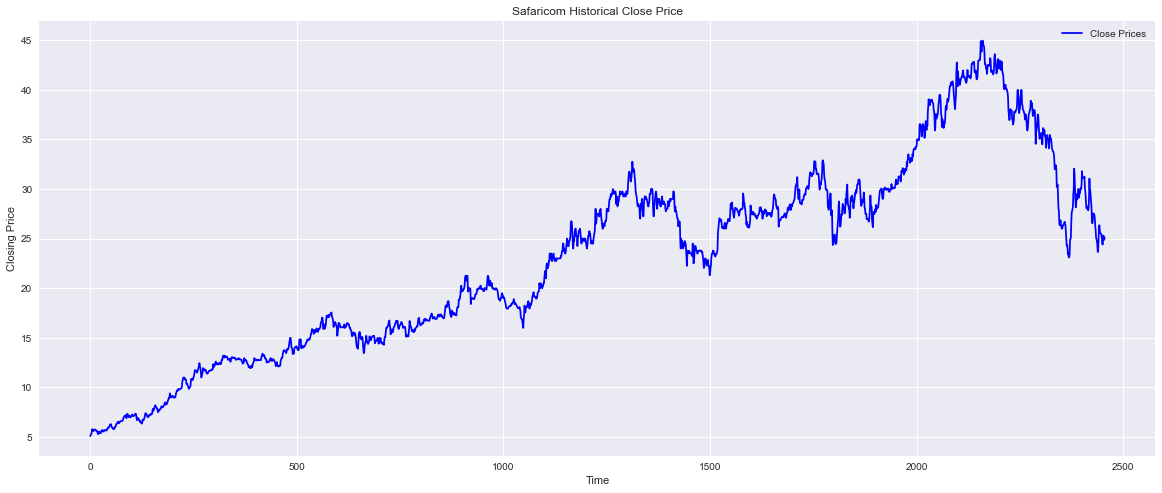

In [8]:
## Plotting the Close Prices
plt.figure(figsize= (20,8))
plt.plot(data['Close'], color= 'blue', label= 'Close Prices')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Safaricom Historical Close Price')
plt.legend()

### Obtaining Stock Returns and Scaling

In [9]:
## Stock Returns
data= data[['Open', 'High', 'Low', 'Close']]
returns= data/data.shift(1)
returns= returns.tail(-1)
returns

,Open,High,Low,Close
1,1.020000,1.019417,1.020000,1.009804
2,1.019608,1.019048,1.009804,1.019417
3,1.000000,1.018692,1.009709,1.019048
4,1.038462,1.073394,1.038462,1.046729
5,1.046296,1.025641,1.018519,1.035714
...,...,...,...,...
2451,1.006160,1.010000,1.010309,1.022541
2452,1.036735,1.009901,1.020408,1.014028
2453,1.003937,1.000000,0.984000,0.982213
2454,1.000000,1.000000,1.008130,1.010060


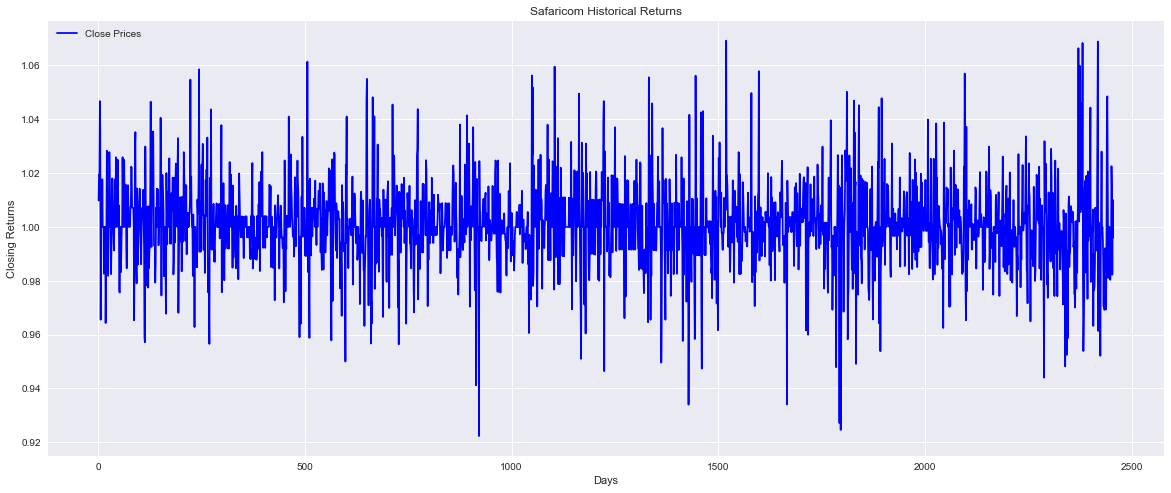

In [10]:
## Plotting Closing Returns
plt.figure(figsize= (20,8))
plt.plot(returns['Close'], color= 'blue', label= 'Close Prices')

plt.xlabel('Days')
plt.ylabel('Closing Returns')
plt.title('Safaricom Historical Returns')
plt.legend()

In [11]:
### ADF Test for Stationarity
x= returns['Close'].values
result= adfuller(x)

print('ADF Statistic:', result[0])
print('P-Value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))

if result[0] < result[4]['5%']:
    print('Reject Ho- Time series is stationary')
else:
    print('Failed to reject Ho- Time series not stationary')

ADF Statistic: -16.37950900841373
P-Value: 2.7602605110123815e-29
Critical Values:
	1%: -3.433028
	5%: -2.862723
	10%: -2.567400
Reject Ho- Time series is stationary


In [12]:
## Normalising Closing Returns between 0 and 1
close= returns['Close'].values
scaler= MinMaxScaler(feature_range= (0,1))
scaled= scaler.fit_transform(np.array(close).reshape(-1,1))
print('shape:', scaled.shape)
print('length:', len(scaled))
print()
scaled

shape: (2455, 1)
length: 2455



array([[0.59572554],
       [0.6611788 ],
       [0.65866066],
       ...,
       [0.40787752],
       [0.5974715 ],
       [0.50185093]])

### Data Preparation

In [13]:
## Splitting the Data for training and testing
train_size= int(len(scaled)* 0.80)
test_size= len(scaled)- train_size

train, test= scaled[0:train_size,:], scaled[train_size:len(scaled),:1]

print('Train:', len(train))
print('Test:', len(test))

Train: 1964
Test: 491


In [14]:
## Creating a Time Series Dataset for LSTM
def create_ds(dataset, step): 
    Xtrain, Ytrain= [], []
    for i in range(len(dataset)-step-1):
        a= dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

## Having our prediction days as 100 (How many days the model will look back into the data to predict the next future value)
days= 72
x_train, y_train= create_ds(train, days)
x_test, y_test= create_ds(test, days)

## Reshaping the Data to fit into the LSTM Model (into a 3D array)
x_train= x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test= x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

### Building the LSTM Model

In [26]:
def build_model(hp):
    model= Sequential()
    for i in range(hp.Int('layers', 2, 3)):
        model.add(LSTM(units= hp.Int('units_' + str(i), 10, 200, step= 10), 
                       return_sequences= hp.Choice('ret_' + str(i), ['True', 'False']), 
                       input_shape= (x_train.shape[1], 1)))
        model.add(Dropout(0.1))
    model.add(Dense(units= 1, activation= hp.Choice('act_1', ['relu', 'sigmoid'])))
    
    es= EarlyStopping(monitor= 'val_loss', min_delta= 1e-10, patience= 10, verbose= 1)
    rlr= ReduceLROnPlateau(monitor= 'val_loss', factor= 0.5, patience= 10, verbose= 1)
    
    model.compile(keras.optimizers.Adam(learning_rate= 0.01), loss= 'mean_squared_error')
    return model

tuner= RandomSearch(build_model, objective= 'loss', max_trials= 3, executions_per_trial= 2, 
                    directory= 'direct_saf1', project_name= 'safcom1')

tuner.search_space_summary()

Search space summary
Default search space size: 6
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
ret_0 (Choice)
{'default': 'True', 'conditions': [], 'values': ['True', 'False'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
ret_1 (Choice)
{'default': 'True', 'conditions': [], 'values': ['True', 'False'], 'ordered': False}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}


In [27]:
tuner.search(x_train, y_train, epochs= 100, batch_size= 32,
             validation_data= (x_test, y_test), validation_split= 0.2)

Trial 3 Complete [00h 52m 27s]
loss: 0.010668288916349411

Best loss So Far: 0.010668288916349411
Total elapsed time: 02h 18m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

In [16]:
model= Sequential()

model.add(LSTM(units= 150, return_sequences= True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.05))
model.add(LSTM(units= 70, return_sequences= True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.05))
model.add(LSTM(units= 60, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.05))
model.add(Dense(units= 1, activation= 'relu'))

es= EarlyStopping(monitor= 'loss', min_delta= 1e-10, patience= 10, verbose= 1)
rlr= ReduceLROnPlateau(monitor= 'loss', factor= 0.5, patience= 10, verbose= 1)
          
model.compile(keras.optimizers.Adam(learning_rate= 0.001), loss= 'mean_squared_error')
model.fit(x_train, y_train, epochs= 100, batch_size= 32, callbacks= [es, rlr], validation_split= 0.2)

Epoch 1/100
48/48 [==============================] - 85s 545ms/step - loss: 0.0269 - val_loss: 0.0123 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 17s 346ms/step - loss: 0.0119 - val_loss: 0.0122 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 15s 310ms/step - loss: 0.0116 - val_loss: 0.0122 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 15s 308ms/step - loss: 0.0116 - val_loss: 0.0122 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 14s 302ms/step - loss: 0.0115 - val_loss: 0.0123 - lr: 0.0010
Epoch 6/100
48/48 [==============================] - 15s 312ms/step - loss: 0.0117 - val_loss: 0.0128 - lr: 0.0010
Epoch 7/100
48/48 [==============================] - 15s 301ms/step - loss: 0.0111 - val_loss: 0.0129 - lr: 0.0010
Epoch 8/100
48/48 [==============================] - 14s 297ms/step - loss: 0.0119 - val_loss: 0.0121 - lr: 0.0010
Epoch 9/100
48/48 [==============================] - 14s 296ms/step - loss: 0.01

Text(0.5, 1.0, 'Plot of Mean Sqaured Error per Increasing Epochs')

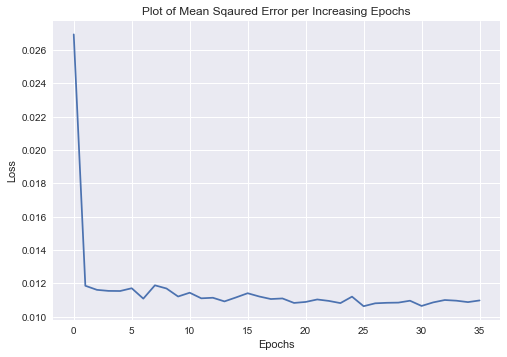

In [17]:
loss= model.history.history['loss']
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Mean Sqaured Error per Increasing Epochs')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 72, 150)           91200     
                                                                 
 dropout_3 (Dropout)         (None, 72, 150)           0         
                                                                 
 lstm_4 (LSTM)               (None, 72, 70)            61880     
                                                                 
 dropout_4 (Dropout)         (None, 72, 70)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60)                31440     
                                                                 
 dropout_5 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

### Testing Model Accuracy

In [19]:
## Predicting the test data
test_predict= model.predict(x_test)

## Getting actual test values
test_predict= scaler.inverse_transform(test_predict)
returnss= scaler.inverse_transform(y_test.reshape(-1,1))

print('(Predicted)', '(Actual)')

for i in range(100):
    print(test_predict[i], returnss[i])

14/14 [==============================] - 13s 87ms/step
(Predicted) (Actual)
[1.0004258] [1.]
[1.0005147] [0.99358974]
[1.0006005] [0.99870968]
[1.0006742] [0.99741602]
[1.0007309] [0.98445596]
[1.0007889] [0.99605263]
[1.0008332] [0.98546896]
[1.0008692] [0.96246649]
[1.0009358] [1.00696379]
[1.0009624] [1.03872752]
[1.0008613] [1.]
[1.0006884] [0.98801598]
[1.0005134] [1.00673854]
[1.0003392] [1.00133869]
[1.0001796] [1.0040107]
[1.0000422] [1.01464714]
[0.9999135] [1.01312336]
[0.99979526] [1.00777202]
[0.99970305] [1.01413882]
[0.99963623] [1.]
[0.9996168] [1.00126743]
[0.99964935] [0.98101266]
[0.9997573] [0.97032258]
[0.9999523] [0.99335106]
[1.0001761] [0.97054886]
[1.0004201] [1.02206897]
[1.0005836] [0.99190283]
[1.0006725] [1.00136054]
[1.0006901] [0.98233696]
[1.0006769] [1.00414938]
[1.0006204] [1.00688705]
[1.0005156] [1.00273598]
[1.0003812] [1.01227831]
[1.0002209] [1.02830189]
[1.0000213] [1.00655308]
[0.9998302] [0.98958333]
[0.99970734] [1.01052632]
[0.9996388] [1.0156

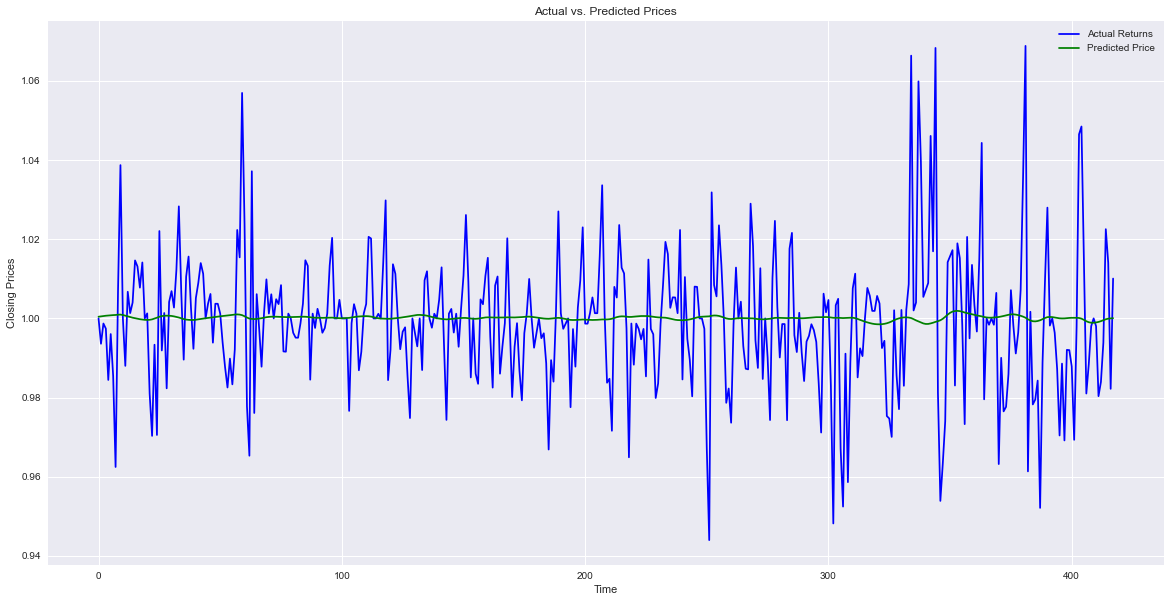

In [20]:
## Plotting the predictions
plt.figure(figsize= (20,10))
plt.plot(returnss, color= 'blue', label= 'Actual Returns')
plt.plot(test_predict, color= 'green', label= 'Predicted Price')

plt.xlabel('Time')
plt.ylabel('Closing Prices')
plt.title('Actual vs. Predicted Prices')
plt.legend()

### Future Predictions

In [21]:
len(test)

491

In [22]:
## Creating a list of the last 100 days
lastlast= test[len(test)- 72:]
lastlast= lastlast.reshape(1,-1)

last= list(lastlast)
last= last[0].tolist()


## Creating a Sliding Window where the next 30 days will be predicted
output= []
n_steps= 72
i= 0

while (i<30):
    if(len(last)> 72):
        lastlast= np.array(last[1:]) # Creates an array of (100,) from the list
        lastlast= lastlast.reshape(1,-1) # Reshapes the array to (1, 100)
        lastlast= lastlast.reshape((1, n_steps, 1)) # Reshapes the array to (1, 100, 1)
        yhat= model.predict(lastlast, verbose= 0) # Predictions are made
        last.extend(yhat[0].tolist()) # Predictions are placed in a list
        last= last[1:]
        output.extend(yhat.tolist()) # extend() can add multiple individual elements to the end of the list while append() adds a single element to the end of the list
        i= i+1
    else:
        lastlast= lastlast.reshape(1, n_steps, 1)
        yhat= model.predict(lastlast, verbose= 0)
        last.extend(yhat[0].tolist())
        output.extend(yhat.tolist())
        i=i+1

output  

[[0.5295625925064087],
 [0.529586136341095],
 [0.5295997858047485],
 [0.529617428779602],
 [0.5296449065208435],
 [0.5296833515167236],
 [0.5297314524650574],
 [0.5297865867614746],
 [0.529845654964447],
 [0.5299056768417358],
 [0.5299643278121948],
 [0.5300196409225464],
 [0.530070424079895],
 [0.5301157832145691],
 [0.5301552414894104],
 [0.530189037322998],
 [0.5302174687385559],
 [0.5302407145500183],
 [0.5302597880363464],
 [0.5302749276161194],
 [0.5302868485450745],
 [0.5302962064743042],
 [0.530303418636322],
 [0.5303090810775757],
 [0.5303135514259338],
 [0.5303168892860413],
 [0.5303195118904114],
 [0.5303217172622681],
 [0.5303233861923218],
 [0.5303247570991516]]

In [23]:
## Forecasted Predictions
forecasted= scaler.inverse_transform(output) # 30 days predictions
print(forecasted)

[[1.00008613]
 [1.00008959]
 [1.00009159]
 [1.00009419]
 [1.00009822]
 [1.00010387]
 [1.00011093]
 [1.00011903]
 [1.00012771]
 [1.00013652]
 [1.00014514]
 [1.00015326]
 [1.00016072]
 [1.00016738]
 [1.00017318]
 [1.00017814]
 [1.00018232]
 [1.00018573]
 [1.00018853]
 [1.00019076]
 [1.00019251]
 [1.00019388]
 [1.00019494]
 [1.00019577]
 [1.00019643]
 [1.00019692]
 [1.0001973 ]
 [1.00019763]
 [1.00019787]
 [1.00019808]]


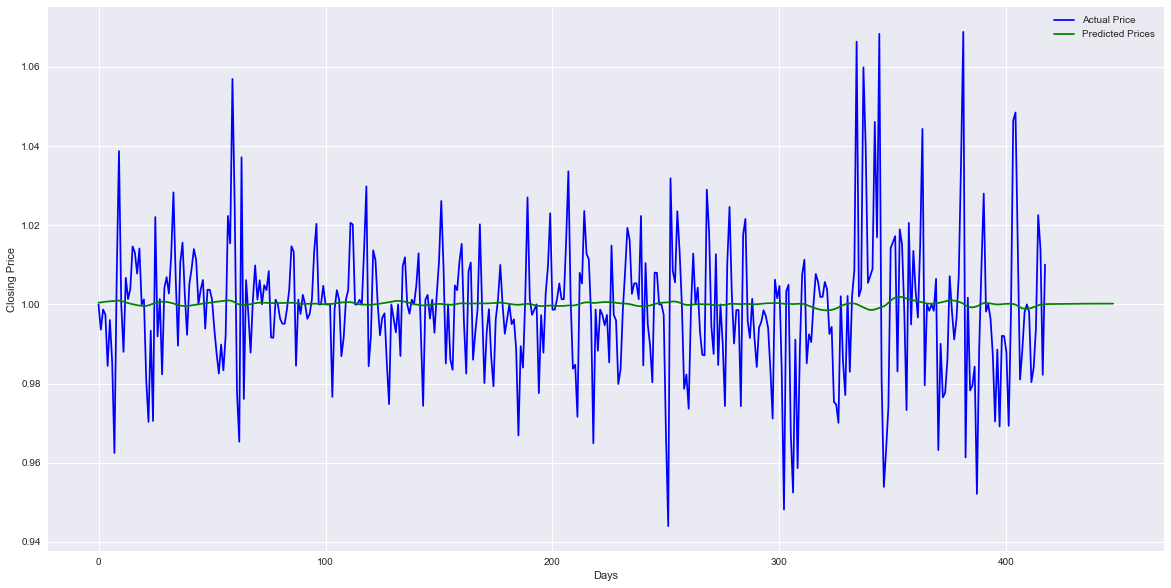

In [36]:
## Plotting the predictions
new= test_predict.tolist()
newpred= forecasted.tolist()
new= new + newpred

plt.figure(figsize= (20,10))
forecasted= scaler.inverse_transform(output) # 30 days predictions
actual= returnss # Actual prices
tested= test_predict

 # We first need to create a dummy plane
plot_new= np.arange(len(returnss))
plot_newer= np.arange(len(new))

 # Plotting the prices
plt.plot(plot_new, actual, color= 'blue', label= 'Actual Price')
plt.plot(plot_newer, new, color= 'green', label= 'Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()

In [25]:
new= test_predict.tolist()
newpred= forecasted.tolist()
new= new + newpred
new

[[1.0004258155822754],
 [1.0005147457122803],
 [1.0006004571914673],
 [1.0006742477416992],
 [1.0007308721542358],
 [1.000788927078247],
 [1.0008331537246704],
 [1.0008691549301147],
 [1.0009357929229736],
 [1.0009623765945435],
 [1.0008612871170044],
 [1.0006884336471558],
 [1.0005134344100952],
 [1.000339150428772],
 [1.000179648399353],
 [1.000042200088501],
 [0.9999135136604309],
 [0.9997952580451965],
 [0.999703049659729],
 [0.9996362328529358],
 [0.999616801738739],
 [0.9996493458747864],
 [0.9997572898864746],
 [0.9999523162841797],
 [1.0001760721206665],
 [1.000420093536377],
 [1.0005836486816406],
 [1.000672459602356],
 [1.0006901025772095],
 [1.0006768703460693],
 [1.0006203651428223],
 [1.0005155801773071],
 [1.0003812313079834],
 [1.0002208948135376],
 [1.0000213384628296],
 [0.9998301863670349],
 [0.9997073411941528],
 [0.9996387958526611],
 [0.9996017217636108],
 [0.9996070265769958],
 [0.9996717572212219],
 [0.999771237373352],
 [0.9998777508735657],
 [0.9999690651893616

In [26]:
pn= plot_new.reshape(-1,1)
pn.shape

(418, 1)